This lab on Polynomial Regression and Step Functions is a python adaptation of p. 288-292 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

%matplotlib inline

# 7.8.1 Polynomial Regression and Step Functions

In this lab, we'll explore how to generate the `Wage` dataset models we saw in class.

In [3]:
import statsmodels.datasets as smd
df =smd.get_rdataset('Wage', 'ISLR').data
# df = pd.read_csv('Wage.csv')
df.head(3)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


We first fit the polynomial regression model using the following commands:

In [4]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

This syntax fits a linear model, using the `PolynomialFeatures()` function, in order to predict
wage using up to a fourth-degree polynomial in `age`. The `PolynomialFeatures()` command
allows us to avoid having to write out a long formula with powers
of `age`. We can then fit our linear model:

In [5]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Next we consider the task of predicting whether an individual earns more
than \$250,000 per year. We proceed much as before, except that first we
create the appropriate response vector, and then we fit a logistic model using the `GLM()` function from `statsmodels`:

In [8]:
# Create response matrix
y = (df.wage > 250).map({False:0, True:1})
#.as_matrix()
print(y)

# Fit logistic model
clf = sm.GLM(y, X4, family=sm.families.Binomial())
res = clf.fit()

231655    0
86582     0
161300    0
155159    0
11443     0
         ..
376816    0
302281    0
10033     0
14375     0
453557    0
Name: wage, Length: 3000, dtype: int64


We now create a grid of values for `age` at which we want predictions, and
then call the generic `predict()` function for each model:

In [9]:
# Generate a sequence of age values spanning the range
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

# Generate test data
X_test = PolynomialFeatures(4).fit_transform(age_grid)

# Predict the value of the generated ages
pred1 = fit2.predict(X_test) # salary
pred2 = res.predict(X_test)  # Pr(wage>250)

Finally, we plot the data and add the fit from the degree-4 polynomial.

Text(0, 0.5, 'Pr(wage>250|age)')

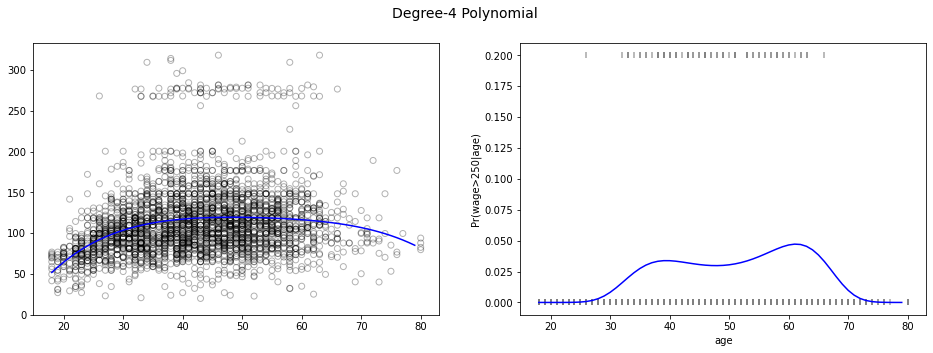

In [10]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred1, color = 'b')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred2, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

# Deciding on a degree

In performing a polynomial regression we must decide on the degree of
the polynomial to use. One way to do this is by using hypothesis tests. We
now fit models ranging from linear to a degree-5 polynomial and seek to
determine the simplest model which is sufficient to explain the relationship
between `wage` and `age`.

We can do this using the `anova_lm()` function, which performs an
analysis of variance (ANOVA, using an F-test) in order to test the null
hypothesis that a model $M_1$ is sufficient to explain the data against the 
alternative hypothesis that a more complex model $M_2$ is required. In order
to use the `anova_lm()` function, $M_1$ and $M_2$ must be **nested models**: the
predictors in $M_1$ must be a subset of the predictors in $M_2$. In this case,
we fit five different models and sequentially compare the simpler model to
the more complex model (*Note:* you may get an *invalid value* Runtime Warning on the first model, because there is no "simpler model" to compare to):

In [11]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

print(sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1))

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


The $p$-value comparing the linear Model 1 to the quadratic Model 2 is
essentially zero $(<10^{-32})$, indicating that a linear fit is not sufficient. Similarly
the $p$-value comparing the quadratic Model 2 to the cubic Model 3
is very low (0.0017), so the quadratic fit is also insufficient. The $p$-value
comparing the cubic and degree-4 polynomials, Model 3 and Model 4, is approximately
0.05 while the degree-5 polynomial Model 5 seems unnecessary
because its $p$-value is 0.37. Hence, either a cubic or a quartic polynomial
appear to provide a reasonable fit to the data, but lower- or higher-order
models are not justified.

As an alternative to using hypothesis tests and ANOVA, we could choose
the polynomial degree using cross-validation as we have in previous labs.

# Step functions
In order to fit a step function, we use the `cut()` function:

In [12]:
df_cut, bins = pd.cut(df.age, 4, retbins = True, right = True)
df_cut.value_counts(sort = False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

Here `cut()` automatically picked the cutpoints at 33.5, 49, and 64.5 years
of age. We could also have specified our own cutpoints directly. Now let's create a set of dummy variables for use in the regression:

In [13]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys = ['age','age_cuts','wage'], axis = 1)

# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

# Drop the (17.938, 33.5] category
df_steps_dummies = df_steps_dummies.drop(df_steps_dummies.columns[1], axis = 1)

df_steps_dummies.head(5)

,const,"(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,0,0,0
86582,1.0,0,0,0
161300,1.0,1,0,0
155159,1.0,1,0,0
11443,1.0,0,1,0


An now to fit the models! We dropped the `age<33.5` category, so the intercept coefficient of
\$94,160 can be interpreted as the average salary for those under 33.5 years
of age. The other coefficients can be interpreted as the average additional
salary for those in the other age groups. 

In [14]:
fit3 = sm.GLM(df_steps.wage, df_steps_dummies).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


We can produce predictions
and plots just as we did in the case of the polynomial fit.

Text(0, 0.5, 'Pr(wage>250|age)')

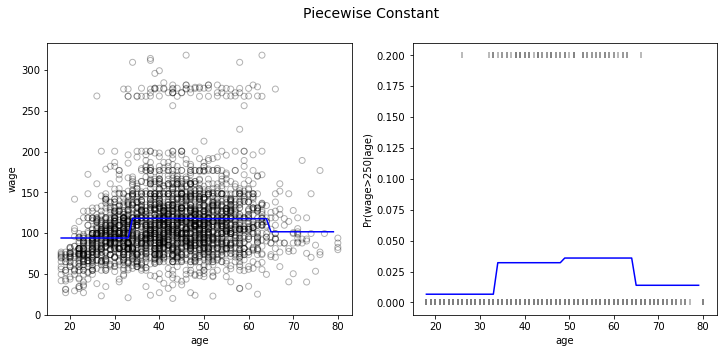

In [16]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)

# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis = 1))

# Predict the value of the generated ages using the linear model
pred2 = fit3.predict(X_test2)

# And the logistic model
clf2 = sm.GLM(y, df_steps_dummies,
              family=sm.families.Binomial())
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Piecewise Constant', fontsize = 14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor = 'None', edgecolor = 'k', alpha = 0.3)
ax1.plot(age_grid, pred2, c = 'b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin = 0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color = 'b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s = 30, c = 'grey', marker = '|', alpha = 0.7)

ax2.set_ylim(-0.01, 0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

In [17]:
sm.families.Binomial?

Init signature: sm.families.Binomial(link=None)
Docstring:     
Binomial exponential family distribution.

Parameters
----------
link : a link instance, optional
    The default link for the Binomial family is the logit link.
    Available links are logit, probit, cauchy, log, loglog, and cloglog.
    See statsmodels.genmod.families.links for more information.

Attributes
----------
Binomial.link : a link instance
    The link function of the Binomial instance
Binomial.variance : varfunc instance
    ``variance`` is an instance of
    statsmodels.genmod.families.varfuncs.binary

See Also
--------
statsmodels.genmod.families.family.Family : Parent class for all links.
:ref:`links` : Further details on links.

Notes
-----
endog for Binomial can be specified in one of three ways:
A 1d array of 0 or 1 values, indicating failure or success
respectively.
A 2d array, with two columns. The first column represents the
success count and the second column represents the failure
count.
A 1d array 

In [19]:
sm.families.links.Logit()